In [1]:
import os
import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import geopandas as gpd
import copy

In [103]:
# def createGraph(df, _fpid='fpid', _tpid='tpid', _id='id', _material='rmat', _diameter='diameter', _construction_year='anlar', _detailtype='detailtype', _npv1='npv1', _npv2='npv2', _length='length'):
def createGraph(df, _id='id', _fpid='fpid', _tpid='tpid', _npv1='npv1', _npv2='npv2', _length='length'):
    G = nx.DiGraph()
    for row in df.iterrows():
        rowCols = row[1]
        G.add_edge(
            rowCols[_fpid],
            rowCols[_tpid],
            id=rowCols[_id],
            npv1=rowCols[_npv1],
            npv2=rowCols[_npv2],
            npv1_status=pd.NA,
            npv2_status=pd.NA,
            fpidType=rowCols[_fpid][0:3],
            tpidType=rowCols[_tpid][0:3],
            length=rowCols[_length],
            original_edge=(rowCols[_fpid], rowCols[_tpid]),
        )

    nodeAttributes = dict()
    for node in G.nodes:
        incomingEdges = list(G.in_edges(node))
        outgoingEdges = list(G.out_edges(node))
        incInvLvl = np.zeros(len(incomingEdges))
        outInvLvl = np.zeros(len(outgoingEdges))
        for i, edge in enumerate(incomingEdges):
            u, v = edge
            incInvLvl[i] = G[u][v]['npv2']
        for i, edge in enumerate(outgoingEdges):
            u, v = edge
            outInvLvl[i] = G[u][v]['npv1']

        if incInvLvl.shape[0] == 0:
            incInvLvl = np.array([np.nan])
        else:
            pass
        if outInvLvl.shape[0] == 0:
            outInvLvl = np.array([np.nan])
        else:
            pass
        nodeAttributes[node] = {'incInvLvl': np.max(incInvLvl), 'outInvLvl': np.min(outInvLvl), 'detailType': node[:3], 'originalId': node}
    nx.set_node_attributes(G, nodeAttributes)
    return G

In [104]:
def findUniquePaths(G, startingNode, depth, direction, breakNodes=False):
    # single_source_shortest_path
    if direction == 'upstream':
        allPaths = nx.single_target_shortest_path(G, startingNode, cutoff=depth)
    elif direction == 'downstream':
        allPaths = nx.single_source_shortest_path(G, startingNode, cutoff=depth)
    uniquePaths = dict()
    for key in allPaths.keys():
        remainingKeys = [k for k in allPaths.keys() if k != key]
        checkUnique = list()
        for rKey in remainingKeys:
            checkUnique.append(not set(allPaths[key]).issubset(set(allPaths[rKey])))
        if all(checkUnique):
            uniquePaths[key] = allPaths[key]
    
    reducedUniquePaths = list()
    if breakNodes:
        for key in uniquePaths.keys():
            if direction == 'upstream':
                uniquePath = uniquePaths[key][::-1]
            else:
                uniquePath = uniquePaths[key]
            reducedUniquePath = list()
            for nodeName in uniquePath:
                if (nodeName[:3] in breakNodes) and (nodeName != startingNode):
                    reducedUniquePath.append(nodeName)
                    break
                else:
                    reducedUniquePath.append(nodeName)
            if direction == 'upstream':
                reducedUniquePath = reducedUniquePath[::-1]
            else:
                pass
            reducedUniquePaths.append(reducedUniquePath)
    else:
        for key in uniquePaths.keys():
            reducedUniquePaths.append(uniquePaths[key])
    return reducedUniquePaths

In [105]:
def selectPipes(G, flags):
    start, end = flags[0], flags[-1]
    paths_between_generator = list(nx.all_simple_edge_paths(G, source=start, target=end))
    if len(paths_between_generator) < 1:
        return False
    else:
        pass

    allPaths = list()
    for path in paths_between_generator:
        nodes = list()
        for edge in path:
            nodes += list(edge)
        allPaths.append(set(nodes))

    for path in allPaths:
        if set(flags).issubset(path):
            SG = G.subgraph(path)
            break

    DiSG = nx.traversal.bfs_tree(SG, end).reverse()

    for edge in DiSG.edges:
        u, v = edge
        try:
            DiSG[u][v]['id'] = nx.get_edge_attributes(SG, "id")[edge]
        except:
            DiSG[u][v]['id'] = nx.get_edge_attributes(SG, "id")[edge[::-1]]

    pipesInOrder = list()
    for u, v, attr in DiSG.edges(nx.topological_sort(DiSG), data=True):
        pipesInOrder.append(attr['id'])

    # pc.copy("MUID IN ('" + "', '".join(pipesInOrder) + "')")

    nodesInOrder = list(nx.topological_sort(DiSG))
    return nodesInOrder# , pipesInOrder

In [106]:
def createIsolationZones(G):
    isolationNodes = [key for key, val in nx.get_node_attributes(G, 'has_level').items() if val == 1]
    node_attr_dict = dict()
    # return isolationNodes
    for isolationNode in isolationNodes:
        newEdges = list()
        #list(nx.reverse(G).edges(isolationNode, data=True)) + list(G.edges(isolationNode, data=True))
        i = 0
        # for i, (_isolationNode, otherNode, attributes) in enumerate(list(nx.reverse(G).edges(isolationNode, data=True)) + list(G.edges(isolationNode, data=True))):
        for _isolationNode, otherNode, attributes in list(G.edges(isolationNode, data=True)):
            newEdges.append((f'_{_isolationNode}_{i}', otherNode, attributes))
            node_attr_dict[f'_{_isolationNode}_{i}'] = G.nodes(data=True)[_isolationNode]
            i += 1
        
        for _isolationNode, otherNode, attributes in nx.reverse(G).edges(isolationNode, data=True):
            # newEdges.append((f'_{_isolationNode}_{i}', otherNode, attributes))
            newEdges.append((otherNode, f'_{_isolationNode}_{i}', attributes))
            node_attr_dict[f'_{_isolationNode}_{i}'] = G.nodes(data=True)[_isolationNode]
            i += 1

        G.remove_edges_from(list(G.edges(isolationNode)))
        G.remove_node(isolationNode)
        G.add_edges_from(newEdges)#, **attr_dict)
        nx.set_node_attributes(G, node_attr_dict)
        # print(newEdges)
    return G
    mapZoneId = dict()
    for i, discreteGraph in enumerate(nx.connected_components(G)):
        mapZoneId.update({key: i for key in nx.get_edge_attributes(G.subgraph(discreteGraph), 'ID').values()})
        df.loc[:, 'zoneId'] = df.index.map(mapZoneId)
    return df

In [107]:
def _interpolate_water_level(G, nodes):
    if len(nodes)>2:
        G.get_edge_data(*nodes[0:2])['npv1'] = G.nodes(data=True)[nodes[0]]['min_level']
        G.get_edge_data(*nodes[-2:])['npv2'] = G.nodes(data=True)[nodes[-1]]['max_level'] 

        length = list()
        for u, v in zip(nodes[0:-1], nodes[1:]):
            length.append(G[u][v]['length'])
        total_length = sum(length)
        slope = (G.nodes(data=True)[nodes[0]]['min_level'] - G.nodes(data=True)[nodes[-1]]['max_level']) / total_length

        if np.isnan(G.get_edge_data(*nodes[0:2])['npv2']):
            G.get_edge_data(*nodes[0:2])['npv2'] = G.get_edge_data(*nodes[0:2])['npv1'] - G.get_edge_data(*nodes[0:2])['length'] * slope
            G.get_edge_data(*nodes[0:2])['npv2_status'] = 'interpolated'
        else:
            pass
        prev_u, prev_v = nodes[0:2]

        for u, v in zip(nodes[1:-2], nodes[2:-1]):
            G.get_edge_data(u, v)['npv1'] = G.get_edge_data(prev_u, prev_v)['npv2']
            G.get_edge_data(u, v)['npv1_status'] = 'interpolated'

            G.get_edge_data(u, v)['npv2'] = G.get_edge_data(u, v)['npv1'] - G.get_edge_data(u, v)['length'] * slope
            G.get_edge_data(u, v)['npv2_status'] = 'interpolated'
            prev_u, prev_v = u, v
            
        if np.isnan(G.get_edge_data(*nodes[-2:])['npv1']):
            G.get_edge_data(*nodes[-2:])['npv1'] = G.get_edge_data(prev_u, prev_v)['npv2']
            G.get_edge_data(*nodes[-2:])['npv1_status'] = 'interpolated'
        else:
            pass

        for u, v in zip(nodes[0:-1], nodes[1:]):
            nx.set_node_attributes(G, {u: {'bottom_level': G[u][v]['npv1']}})
            nx.set_node_attributes(G, {v: {'bottom_level': G[u][v]['npv2']}})
    else:           
        if G.get_edge_data(*nodes[0:2])['npv1'] is np.nan:
            G.get_edge_data(*nodes[0:2])['npv1'] = G.nodes(data=True)[nodes[0]]['min_level']
        elif G.get_edge_data(*nodes[-2:])['npv2'] is np.nan:
            G.get_edge_data(*nodes[-2:])['npv2'] = G.nodes(data=True)[nodes[-1]]['max_level'] 
    return G

In [108]:
def update_has_level(G, subset=False):
    if subset:
        pass
    else:
        subset = list(G.nodes())
        
    for node in G.subgraph(subset).nodes(data=False):
        incoming_levels = list()
        outgoing_levels = list()
        for u, v in G.in_edges(node):
            incoming_levels.append(G[u][v]['npv2'])
        for u, v in G.out_edges(node):
            outgoing_levels.append(G[u][v]['npv1'])
        invert_levels = np.array(incoming_levels + outgoing_levels)
        invert_levels = invert_levels[~np.isnan(invert_levels)]
        if invert_levels.shape[0] > 0:
            if G.nodes(data=True)[node]['has_level'] == 0:
                nx.set_node_attributes(G, {node: {'max_level': np.max(invert_levels), 'min_level': np.min(invert_levels), 'has_level': 1}})
            else:
                pass
        else:
            pass
    return G

In [109]:
def calculate_downstream_nodes(G, c):
    nodes_with_level = [key for key, val in nx.get_node_attributes(G.subgraph(c), 'has_level').items() if val ==1]
    downstream_nodes = list()
    for node in c:
        if G.out_degree(node) == 0:
            downstream_nodes.append(node)
    

    downstream_nodes = [n for n in downstream_nodes if G.nodes(data=True)[n]['has_level'] == 1]
    if len(downstream_nodes) < 1:
        return False, None
        # continue
    else:
        downstream_nodes_levels = [G.nodes(data=True)[n]['max_level'] for n in downstream_nodes]
        downstream_nodes = [x for _, x in sorted(zip(downstream_nodes_levels, downstream_nodes), key = lambda pair: pair[0], reverse=True)]
        downstream_nodes_levels = sorted(downstream_nodes_levels, reverse=True)    
        highest_node_downstream = downstream_nodes[0]
        return downstream_nodes, highest_node_downstream

    upstream_paths = findUniquePaths(H, highest_node_downstream, 20, 'upstream', breakNodes=False)
    upstream_nodes = [path[0] for path in upstream_paths]
    upstream_nodes = [n for n in upstream_nodes if H.nodes(data=True)[n]['has_level'] == 1]

In [110]:
def calculate_upstream_nodes(G, highest_node_downstream):
    upstream_paths = findUniquePaths(G, highest_node_downstream, 20, 'upstream', breakNodes=False)
    upstream_nodes = [path[0] for path in upstream_paths]
    upstream_nodes = [n for n in upstream_nodes if G.nodes(data=True)[n]['has_level'] == 1]
    return upstream_nodes, upstream_paths

In [141]:
def extrapolate_invert_level(H_, upstream_paths, slope, kntrl=0):
    ## Add some if-statements to prevent overwriting
    H_i = copy.deepcopy(H_)
    for path in upstream_paths:
        path = list(reversed(path))

        u, v = path[1], path[0]
        # print('Hej', u, v)
        # print(H_i.get_edge_data(u, v))
        H_i[u][v]['npv1'] = H_i[u][v]['npv2'] + H_i[u][v]['length'] * slope
        H_i[u][v]['npv1_status'] = 'extrapolated'

        prev_u, prev_v = u, v

        for u, v in zip(path[2:], path[1:]):
            delta_h = H_i[u][v]['length'] * slope
            # if kntrl == 1:
                # print(delta_h)
            H_i[u][v]['npv2'] = H_i[prev_u][prev_v]['npv1']
            H_i[u][v]['npv2_status'] = 'extrapolated'

            H_i[u][v]['npv1'] = H_i[u][v]['npv2'] + delta_h
            H_i[u][v]['npv1_status'] = 'extrapolated'
            prev_u, prev_v = u, v
    return H_i


In [180]:
## Kod för att exptrapolera inom zoner där det både finns uppströmsnoder med- och utan vattengång


def calculate_new_invert_levels(pipes, _id, _fpid, _tpid, _npv1, _npv2, _length):
    H = createGraph(pipes, _id=_id, _fpid=_fpid, _tpid=_tpid, _npv1=_npv1, _npv2=_npv2, _length=_length)
    B = copy.deepcopy(H)
    nx.set_node_attributes(H, 0, 'has_level')
    
    ###########################################
    ##   Hämta vattengång från närliggande   ##
    ###########################################

    # mask = np.unique(np.concatenate([pipes.loc[pipes[_npv1].notnull(), _fpid], pipes.loc[pipes[_npv2].notnull(), _tpid]]))
    nodes_with_edges_without_invert_level = np.unique(np.concatenate([pipes.loc[pipes[_npv1].isnull(), _fpid], pipes.loc[pipes[_npv2].isnull(), _tpid]]))

    for node in nodes_with_edges_without_invert_level:
        incoming_invert_levels = list()
        outgoing_invert_levels = list()
        invert_levels = list()
        for edge in H.in_edges(node):
            incoming_invert_level = nx.get_edge_attributes(H, 'npv2')[*edge]
            if np.isnan(incoming_invert_level):
                pass
            else:
                incoming_invert_levels.append(incoming_invert_level)
        for edge in H.out_edges(node):
            outgoing_invert_level = nx.get_edge_attributes(H, 'npv1')[*edge]
            if np.isnan(outgoing_invert_level):
                pass
            else:
                outgoing_invert_levels.append(outgoing_invert_level)
        invert_levels = incoming_invert_levels + outgoing_invert_levels

        has_incoming_invert_levels = np.any([~np.isnan(invert_level) for invert_level in incoming_invert_levels])
        has_outgoing_invert_levels = np.any([~np.isnan(invert_level) for invert_level in outgoing_invert_levels])
        has_invert_levels = has_incoming_invert_levels or has_outgoing_invert_levels

        for u, v in H.in_edges(node):
            incoming_invert_level = nx.get_edge_attributes(H, 'npv2')[u, v]
            if np.isnan(incoming_invert_level):
                if has_incoming_invert_levels:
                    H[u][v]['npv2'] = np.max(incoming_invert_levels)
                    H[u][v]['npv2_status'] = 'other incoming invert level'
                elif has_invert_levels:
                    H[u][v]['npv2'] = np.max(invert_levels)
                    H[u][v]['npv2_status'] = 'outgoing invert level'
                else:
                    continue
        
        for u, v in H.out_edges(node):
            outgoing_invert_level = nx.get_edge_attributes(H, 'npv1')[u, v]
            if np.isnan(outgoing_invert_level):
                if has_outgoing_invert_levels:
                    H[u][v]['npv1'] = np.min(outgoing_invert_levels)
                    H[u][v]['npv1_status'] = 'other outgoing invert level'
                elif has_invert_levels:
                    H[u][v]['npv1'] = np.min(invert_levels)
                    H[u][v]['npv1_status'] = 'incoming invert level'
                else:
                    continue
    

    H = update_has_level(H.copy())
    H = createIsolationZones(H)

    ###########################################
    ##        INTERPOLERA VATTENGÅNG         ##
    ###########################################

    for c in nx.connected_components(H.to_undirected(as_view=True)):
        if len(c) < 2:
            continue
        else:
            pass

        downstream_nodes, highest_node_downstream = calculate_downstream_nodes(H, c)
        if downstream_nodes:
            pass
        else:
            continue

        upstream_nodes, upstream_paths = calculate_upstream_nodes(H, highest_node_downstream)
        if len(upstream_nodes) < 1:
            continue
        else:
            pass
        
        upstream_nodes_levels = [H.nodes(data=True)[n]['max_level'] for n in upstream_nodes]
        upstream_nodes = [x for _, x in sorted(zip(upstream_nodes_levels, upstream_nodes), key = lambda pair: pair[0], reverse=True)]
        upstream_nodes_levels = sorted(upstream_nodes_levels, reverse=True)    
        lowest_node_upstream = upstream_nodes[-1]

        _nodes = selectPipes(nx.Graph(H), (lowest_node_upstream, highest_node_downstream))
        
        H = _interpolate_water_level(H.copy(as_view=False), _nodes)
        H = update_has_level(H, subset=_nodes)

        nodes_with_level = [key for key, val in nx.get_node_attributes(H.subgraph(c), 'has_level').items() if val ==1]
        nodes_with_level = [n for n in nodes_with_level if n not in upstream_nodes]

        nodes_to_update = [n for n in upstream_nodes if H.nodes(data=True)[n]['has_level']==1]
        nodes_to_update_levels = [H.nodes(data=True)[n]['min_level'] for n in nodes_to_update]
        
        nodes_to_update = [x for _, x in sorted(zip(nodes_to_update_levels, nodes_to_update), key = lambda pair: pair[0], reverse=False)]
        nodes_to_update_levels = sorted(nodes_to_update_levels, reverse=False)

        for n in nodes_to_update:
            for node_downstream in downstream_nodes:
                nodes_in_order = selectPipes(nx.Graph(H), (n, node_downstream))
                if nodes_in_order:
                    break
                else:
                    continue
            
            nodes_in_order_reduced = list(set(nodes_in_order).difference(set(nodes_with_level)))
            if len(nodes_in_order_reduced) < 1:
                continue
            else:
                pass

            mask = [True if n not in nodes_with_level else False for n in nodes_in_order]
            nodes_in_order_reduced = list(np.asarray(nodes_in_order)[mask])
            end_node = np.nonzero(nodes_in_order_reduced[-1] == np.asarray(nodes_in_order))[0][0] + 1
            nodes_in_order_reduced.append(nodes_in_order[end_node])

            H = _interpolate_water_level(H.copy(as_view=False), nodes_in_order_reduced)
            H = update_has_level(H, subset=nodes_in_order_reduced)
            nodes_with_level = [key for key, val in nx.get_node_attributes(H.subgraph(c), 'has_level').items() if val ==1]
            nodes_with_level = [n for n in nodes_with_level if n not in upstream_nodes]
        
        ###########################################
        ##   EXTRAPOLERA VATTENGÅNG INOM ZON     ##
        ###########################################

        H_sub = createIsolationZones(nx.DiGraph(nx.subgraph(H, c)))
        for c_sub in nx.connected_components(H_sub.to_undirected(as_view=True)):
            downstream_nodes, highest_node_downstream = calculate_downstream_nodes(H_sub, c_sub)
            if downstream_nodes:
                pass
            else:
                continue

            upstream_nodes, upstream_paths = calculate_upstream_nodes(H_sub, highest_node_downstream)
            if len(upstream_nodes) < 1:
                pass
            else:
                continue
            
            out_edges = H.out_edges(H_sub.nodes(data=True)[highest_node_downstream]['originalId'])
            if len(out_edges) != 1:
                print("The code doesn't support multiple downstream pipes at the moment when extrapolating", 'node:', downstream_u)
                continue
            else:
                out_edge = list(out_edges)[0]
            old_u, old_v = out_edge
                
            _length = H[old_u][old_v]['length']
            _npv1 = H[old_u][old_v]['npv1']
            _npv2 = H[old_u][old_v]['npv2']
            _slope = (_npv1 - _npv2) / _length

            '*******************'
            '*******************'
            H_sub.nodes(data=True)[highest_node_downstream]['originalId']
            for in_edge in H.in_edges(H_sub.nodes(data=True)[highest_node_downstream]['originalId']):
                # print(in_edge)
                if np.isnan(H.edges[*in_edge]['npv2']):
                    H.edges[*in_edge]['npv2'] = _npv1
                    H.edges[*in_edge]['npv2_status'] = 'interpolated'
                else:
                    pass
            '*******************'
            '*******************'

            if ('SNB7162' in c) and ('SNB6909' in c):
                print(c, _npv1)

            for upstream_path in upstream_paths:
                replace_index = upstream_path.index(highest_node_downstream)
                upstream_path[replace_index] = H_sub.nodes(data=True)[highest_node_downstream]['originalId']
            H = extrapolate_invert_level(H, upstream_paths, _slope, 1)

    for u in H.nodes():
        levels_list = list()
        for incoming_edge in H.in_edges(u):
            levels_list.append(nx.get_edge_attributes(H, 'npv2')[*incoming_edge])
        for outgoing_edge in H.out_edges(u):
            levels_list.append(nx.get_edge_attributes(H, 'npv1')[*outgoing_edge])
        
        if np.any([~np.isnan(val) for val in levels_list]):
            lowest_level = np.nanmin(levels_list)
            nx.set_node_attributes(H, {u: {'bottom_level': lowest_level}})
        else:
            nx.set_node_attributes(H, {u: {'bottom_level': np.nan}})

    


    ###########################################
    ##        EXTRAPOLERA VATTENGÅNG         ##
    ###########################################

    for c in nx.connected_components(H.to_undirected(as_view=True)):
        # print(c)
        downstream_nodes, highest_node_downstream = calculate_downstream_nodes(H, c)
        if downstream_nodes:
            pass
        else:
            continue

        upstream_nodes, upstream_paths = calculate_upstream_nodes(H, highest_node_downstream)
        if len(upstream_nodes) < 1:
            pass
        else:
            continue
        
        out_edges = B.out_edges(H.nodes(data=True)[highest_node_downstream]['originalId'])
        if len(out_edges) != 1:
            continue
        else:
            out_edge = list(out_edges)[0]
        old_u, old_v = out_edge





        downstream_u = [n for n in H.nodes(data=False) if old_u == H.nodes(data=True)[n]['originalId'] and highest_node_downstream != n]
        downstream_u = [n for n in downstream_u if len(H.out_edges(n)) > 0]
        if len(downstream_u) > 1:     
            print("The code doesn't support multiple downstream pipes at the moment when extrapolating", 'node:', downstream_u)
            continue
        else:
            pass
    
        
        
        downstream_u = downstream_u[0]
        H.nodes(data=True)[highest_node_downstream]['bottom_level'] = H.nodes(data=True)[downstream_u]['bottom_level']

        downstream_pipe_from_isolation_zone = H.out_edges(downstream_u)
        if len(list(downstream_pipe_from_isolation_zone)) > 1:
            print("The code doesn't support extrapolation when multiple exiting pipes")
            continue
        else:
            downstream_pipe_from_isolation_zone = list(downstream_pipe_from_isolation_zone)[0]
            _npv1, _npv2 = H.get_edge_data(*downstream_pipe_from_isolation_zone)['npv1'], H.get_edge_data(*downstream_pipe_from_isolation_zone)['npv2']
        
        _length = H.edges[*downstream_pipe_from_isolation_zone]['length']
        _slope = (_npv1 - _npv2) / _length

        for in_edge in H.in_edges(highest_node_downstream):
            H.edges[*in_edge]['npv2'] = _npv1
            H.edges[*in_edge]['npv2_status'] = 'interpolated'
        
        H = extrapolate_invert_level(H, upstream_paths, _slope)
        
    to_merge = ['id', 'npv1', 'npv2', 'npv1_status', 'npv2_status']
    df_list = list()
    for column in to_merge:
        df_list.append(pd.DataFrame.from_dict(nx.get_edge_attributes(H, column), columns=[column], orient='index'))
    to_merge_df = pd.concat(df_list, axis=1)
    to_merge_df.set_index('id', inplace=True)
    pipes_update = pd.merge(pipes, to_merge_df.add_suffix('_'), how='left', left_on='ID', right_index=True, suffixes=(None, '_'))
    return pipes_update, H

In [181]:
updtp, _ = calculate_new_invert_levels(pipes, 'ID', 'FPID', 'TPID', 'NPV1', 'NPV2', 'length')

{'SNB7162', '_SNB4764_1', 'STB1842', '_SNB6907_0', 'SNB6909', 'SNB6910'} 28.472803065523568


In [14]:
cwd = Path(r"C:\Users\SEDINI\OneDrive - Sweco AB\scripts\lokala\GIS")

In [23]:
## Måste uppdatera koden så att den alltid kör lägsta upstream först. Men gör den inte redan det?
cwd = Path(r"C:\Users\SEDINI\OneDrive - Sweco AB\scripts\lokala\GIS")
pipes = gpd.read_file(cwd / 'arbetsmaterial.gpkg',
                      layer='testnat',
                      encoding='utf-8'
)

    # Spara original-id som attribut innan delande

In [16]:
pipes = gpd.read_file(cwd / 'arbetsmaterial.gpkg',
                      layer='pipes_subset2',
                      encoding='utf-8'
)

In [184]:
pipes = gpd.read_file(r"C:\Users\SEDINI\Documents\SEDINI_Arbetsmapp\diverse\Sofia Ejderby\Underlag\231016_Underlag_Spillvattenät_modell_A-torp-Falkträsket\LEDNING S.shp")

In [185]:
pipes.replace({'YTTD': {0: np.nan}, 'INND': {0: np.nan}, 'NPV1': {0: np.nan}, 'NPV2': {0: np.nan}}, inplace=True)
pipes = pipes.assign(diameter = pipes.loc[:, ['INND', 'YTTD']].min(axis=1))
pipes = pipes.loc[pipes['FTYP']=='S']
pipes = pipes.assign(length=pipes.geometry.length)

In [186]:
alla_ledningar_interpol, _ = calculate_new_invert_levels(pipes, 'ID', 'FPID', 'TPID', 'NPV1', 'NPV2', 'length')

{'SNB7162', '_SNB4764_1', 'STB1842', '_SNB6907_0', 'SNB6909', 'SNB6910'} 28.472803065523568


In [38]:
[['SNB7162', '_SNB6909_1']][0] == '_SNB6909_1'

False

In [39]:
[['SNB7162', '_SNB6909_1']][0].index('_SNB6909_1')

1

In [50]:
updtp, _ = calculate_new_invert_levels(pipes, 'ID', 'FPID', 'TPID', 'NPV1', 'NPV2', 'length')

['SNB7162', 'SNB6909']
The code doesn't support multiple downstream pipes at the moment when extrapolating node: ['_SNB7211_0', '_SNB7211_2']
The code doesn't support multiple downstream pipes at the moment when extrapolating node: ['_SNB6907_0', '_SNB6907_1', '_SNB6907_3']
The code doesn't support multiple downstream pipes at the moment when extrapolating node: ['_SNB6907_0', '_SNB6907_1', '_SNB6907_2']


In [ ]:
updtp, _ = calculate_new_invert_levels(pipes, 'ID', 'FPID', 'TPID', 'NPV1', 'NPV2', 'length')

Missing NPV2 SNB6910 SNB4764
Missing NPV2 SNB7208 SNB6906
Missing NPV2 SNB7303 SNB6906
Missing NPV2 SPL20337 SNB6906
Missing NPV2 SNB6908 SNB6907
Missing NPV2 SNB6906 SNB6907
Missing NPV2 SNB7165 SNB6907
Missing NPV2 SNB7162 SNB6909
Missing NPV2 SNB6907 SNB6909
Missing NPV2 STB1842 SNB6910
Missing NPV2 SNB7212 SNB7207
Missing NPV2 SNB7207 SNB7208
Missing NPV2 SNB7211 SNB7210
Missing NPV2 SNB7210 SNB7212
Missing NPV2 SRB753 SNB7301
Missing NPV2 SNB7301 SNB7302
Missing NPV2 SNB7302 SNB7303
Missing NPV2 SRB636 SPL20318
Missing NPV2 SRB712 SPL21959
Missing NPV2 SRB746 SPL22219
Missing NPV2 SPL20313 SRB636
Missing NPV2 SPL22230 SRB753
Missing NPV2 SNB6909 STB1842
The code doesn't support multiple downstream pipes at the moment when extrapolating node: ['_SNB7211_0', '_SNB7211_2']
The code doesn't support multiple downstream pipes at the moment when extrapolating node: ['_SNB6907_0', '_SNB6907_1', '_SNB6907_3']
The code doesn't support multiple downstream pipes at the moment when extrapolati

In [183]:
(34.6 - 29.51) / 479.445

0.010616441927645506

In [182]:
updtp.to_file(cwd / 'arbetsmaterial.gpkg',
              layer='interpol_subset2_v5',
              encoding='utf-8'
)

In [187]:
alla_ledningar_interpol.to_file(cwd / 'arbetsmaterial.gpkg',
                                layer='interpol_skelleftea',
                                encoding='utf-8'
)

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\SEDINI\AppData\Local\miniconda3\envs\dataanalys\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\SEDINI\AppData\Local\miniconda3\envs\dataanalys\Lib\asyncio\selector_events.py", line 119, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] En befintlig anslutning tvingades att stänga av fjärrvärddatorn
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\SEDINI\AppData\Local\miniconda3\envs\dataanalys\Lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\SEDINI\AppData\Local\miniconda3\envs\dataanalys\Lib\asyncio\sel

```python
for out_edge in H.out_edges(highest_node_downstream):
    print(out_edge)
```

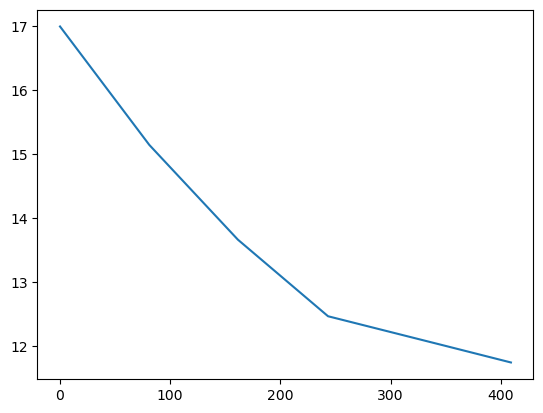

In [75]:
_nodes = ['_SAS308_0', 'SNB24246', 'SNB24245', 'SNB24242', 'SNB24241', 'SNB24244', 'SNB24243', '_SAS321_1']
# _nodes = ['_SAS316_0', 'SNB24244', 'SNB24243', '_SAS321_1']
# _nodes = ['_SNB5280_1', 'SXP379', 'SXP380', 'SNB5458']
# _nodes = ['_SXP380_0', '_SNB5458_1']
length = list()
for u, v in zip(_nodes[0:-1], _nodes[1:]):
    length.append(H[u][v]['length'])
accumulated_length = np.cumsum(length)
plt.plot(np.concatenate([[0], accumulated_length]), [nx.get_node_attributes(H, 'bottom_level')[n] for n in _nodes])

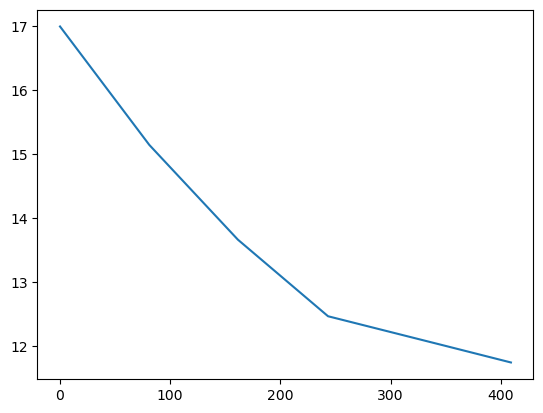

In [101]:
_nodes = ['_SAS308_0', 'SNB24246', 'SNB24245', 'SNB24242', 'SNB24241', 'SNB24244', 'SNB24243', '_SAS321_1']
# _nodes = ['_SAS316_0', 'SNB24244', 'SNB24243', '_SAS321_1']
# _nodes = ['_SNB5280_1', 'SXP379', 'SXP380', 'SNB5458']
# _nodes = ['_SXP380_0', '_SNB5458_1']
length = list()
for u, v in zip(_nodes[0:-1], _nodes[1:]):
    length.append(H[u][v]['length'])
accumulated_length = np.cumsum(length)
plt.plot(np.concatenate([[0], accumulated_length]), [nx.get_node_attributes(H, 'bottom_level')[n] for n in _nodes])

In [70]:
pipes_update.to_file(cwd / 'arbetsmaterial.gpkg',
                     layer='testnat_interpol_9',
                     encoding='utf-8'
)

In [112]:
pipes_update.to_file(cwd / 'arbetsmaterial.gpkg',
                     layer='ledningsnat_interpol',
                     encoding='utf-8'
)

In [71]:
print(cwd)

C:\Users\SEDINI\OneDrive - Sweco AB\scripts\lokala\GIS
